In [6]:
import os
import glob
import librosa
import numpy as np
import soundfile as sf



def time_stretch(filename, output_file, speed_factor):
    # Load the audio file
    audio, sample_rate = librosa.load(filename, sr=None)

    # Apply time stretching to the whole audio file
    stretched_audio = librosa.effects.time_stretch(audio, speed_factor)

    # Save the transformed audio file
    sf.write(output_file, stretched_audio, sample_rate)

input_folder = 'lt400'
output_folder = 'output_folder'
stretch_values = [ 0.85, 0.9, 1, 1.1, 1.2]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_stretch in stretch_values:
    output_folder = os.path.join(output_folder, f'stretch{desired_stretch}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        time_stretch(file, output_filename, desired_stretch)

        

/tmp/ipykernel_19530/1755408775.py:14: FutureWarning: Pass rate=0.85 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  stretched_audio = librosa.effects.time_stretch(audio, speed_factor)
/tmp/ipykernel_19530/1755408775.py:14: FutureWarning: Pass rate=0.9 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  stretched_audio = librosa.effects.time_stretch(audio, speed_factor)
/tmp/ipykernel_19530/1755408775.py:14: FutureWarning: Pass rate=1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  stretched_audio = librosa.effects.time_stretch(audio, speed_factor)
/tmp/ipykernel_19530/1755408775.py:14: FutureWarning: Pass rate=1.1 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  stretched_audio = librosa.effects.time_stretch(audio, speed_factor)
/tmp/ipykernel_19530/1755408775.py:14: FutureWarning: Pass ra

In [4]:
import os
import json
import wave
import sys
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd

def transcribe_files_to_tsv(input_folder, output_filename):
    # Set the log level to 0 to disable debug messages
    SetLogLevel(0)

    model = Model(lang="ca")
    transcriptions = []

    # Iterate through all files in the input folder
    for file in os.listdir(input_folder):
        #print(os.path.basename(file))
        if file.endswith(".wav"):
            wf = wave.open(os.path.join(input_folder, file), "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                print(f"Audio file {file} must be WAV format mono PCM.")
                continue

            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process the audio file
            last = None
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break      
                if rec.AcceptWaveform(data):
                    last = rec.Result()
                else:
                    rec.PartialResult()             
                #if rec.AcceptWaveform(data):
                    
            result_json = rec.Result()
            result_dict = json.loads(result_json)
            if(result_dict["text"] == ""):
                try:
                    result_dict = json.loads(last)   
                except:
                    print("Error") 
            #results = result_dict["result"]
            #print(os.path.basename(file)+"saved")
            transcriptions.append((os.path.basename(file), result_dict["text"]))
            #print(result_dict["text"])
                    

    # Convert the list of transcriptions to a DataFrame
    transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

    # Save the output to a TSV file
    transcriptions_df.to_csv(output_filename, sep="\t", index=False)


import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return 1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer_pesq(original_data, augmented_data, output_file_path, stretch):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{ORIGINAL_FOLDER}/{filename}"
            deg_file_path = f"{augmented_folder}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = 1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            #print("PESQ "+ str(pesq_score)+"WER "+str(wer_score))
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), stretch])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "stretch"])
        writer.writerows(output)



#transcribe_files_to_tsv("lt400/", "lt400.tsv")
transcribe_files_to_tsv("stretch05/", os.path.join("stretch05", "stretch05.tsv"))
transcribe_files_to_tsv("stretch05/", os.path.join("stretch075", "stretch075.tsv"))
transcribe_files_to_tsv("stretch1/", os.path.join("stretch1", "stretch1.tsv"))
transcribe_files_to_tsv("stretch15/", os.path.join("stretch15", "stretch15.tsv"))
transcribe_files_to_tsv("stretch2/", os.path.join("stretch2", "stretch2.tsv"))

ORIGINAL_FOLDER = "lt400"


tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)


augmented_folder = "stretch05"
stretch05_path = Path("stretch05/stretch05.tsv")
stretch05 = read_tsv_file(stretch05_path)
output_stretch05 = Path("OUTPUT05stretch.tsv")

calculate_wer_pesq(tsv_data, stretch05, output_stretch05,0.5)

augmented_folder = "stretch075"
stretch10_path = Path("stretch075/stretch075.tsv")
stretch10 = read_tsv_file(stretch10_path)
output_stretch10 = Path("OUTPUT075stretch.tsv")

calculate_wer_pesq(tsv_data, stretch10, output_stretch10,0.75)


augmented_folder = "stretch1"
stretch20_path = Path("stretch1/stretch1.tsv")
stretch20 = read_tsv_file(stretch20_path)
output_stretch20 = Path("OUTPUT1stretch.tsv")

calculate_wer_pesq(tsv_data, stretch20, output_stretch20,1)

augmented_folder = "stretch15"
stretch30_path = Path("stretch15/stretch15.tsv")
stretch30 = read_tsv_file(stretch30_path)
output_stretch30 = Path("OUTPUT15stretch.tsv")

calculate_wer_pesq(tsv_data, stretch30, output_stretch30,1.5)

augmented_folder = "stretch2"
stretch40_path = Path("stretch2/stretch2.tsv")
stretch40 = read_tsv_file(stretch40_path)
output_stretch40 = Path("OUTPUT2stretch.tsv")

calculate_wer_pesq(tsv_data, stretch40, output_stretch40,2)




/home/lucastakanori/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG

Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

Error
Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.


Error
Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

Error


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

lt400/common_voice_ca_31378986.wav  stretch05/common_voice_ca_31378986.wav
lt400/common_voice_ca_31340819.wav  stretch05/common_voice_ca_31340819.wav
lt400/upc_ca_pau_101129.wav  stretch05/upc_ca_pau_101129.wav
lt400/upc_ca_pau_101059.wav  stretch05/upc_ca_pau_101059.wav
lt400/common_voice_ca_31169713.wav  stretch05/common_voice_ca_31169713.wav
lt400/common_voice_ca_30791849.wav  stretch05/common_voice_ca_30791849.wav
lt400/common_voice_ca_31083166.wav  stretch05/common_voice_ca_31083166.wav
lt400/common_voice_ca_31792858.wav  stretch05/common_voice_ca_31792858.wav
lt400/upc_ca_pau_101070.wav  stretch05/upc_ca_pau_101070.wav
lt400/common_voice_ca_31148020.wav  stretch05/common_voice_ca_31148020.wav
lt400/upc_ca_pau_101022.wav  stretch05/upc_ca_pau_101022.wav
lt400/common_voice_ca_31480904.wav  stretch05/common_voice_ca_31480904.wav
lt400/upc_ca_ona_100029.wav  stretch05/upc_ca_ona_100029.wav
lt400/common_voice_ca_30957869.wav  stretch05/common_voice_ca_30957869.wav
lt400/upc_ca_ona_100

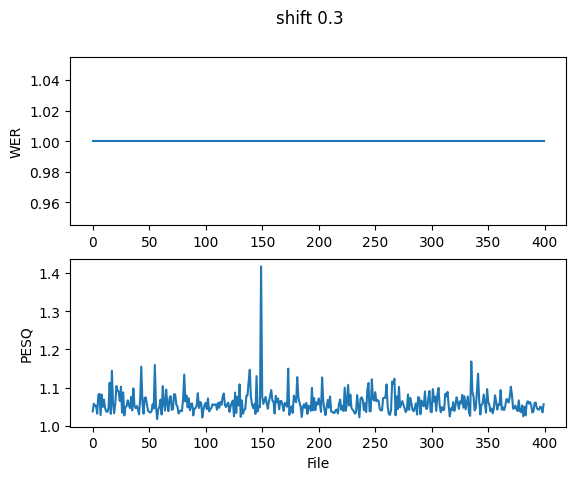

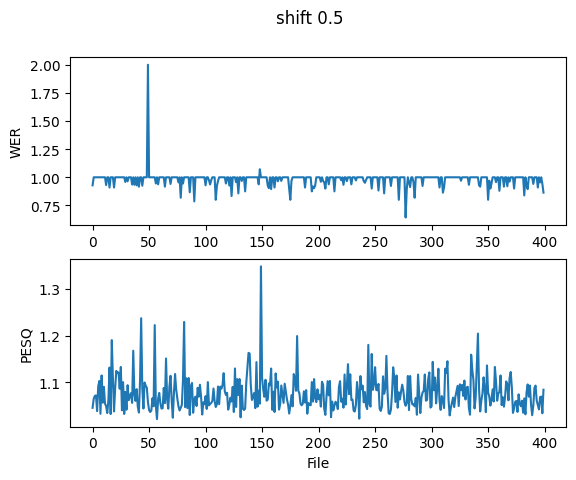

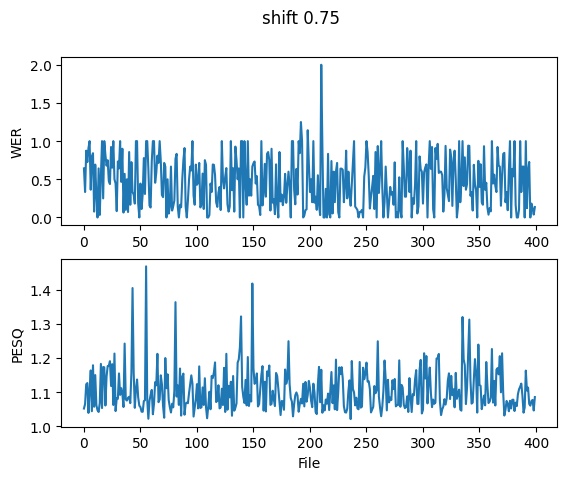

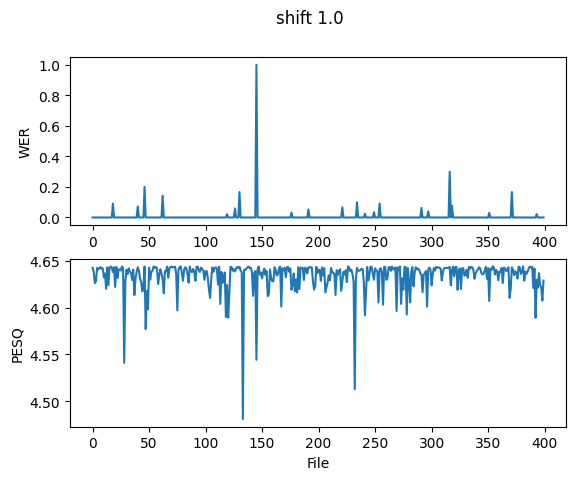

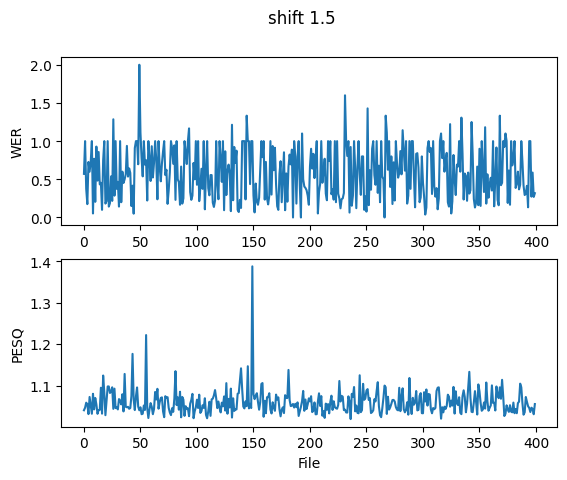

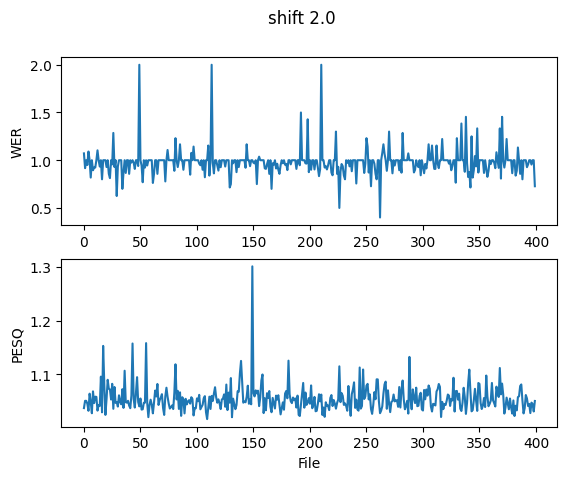

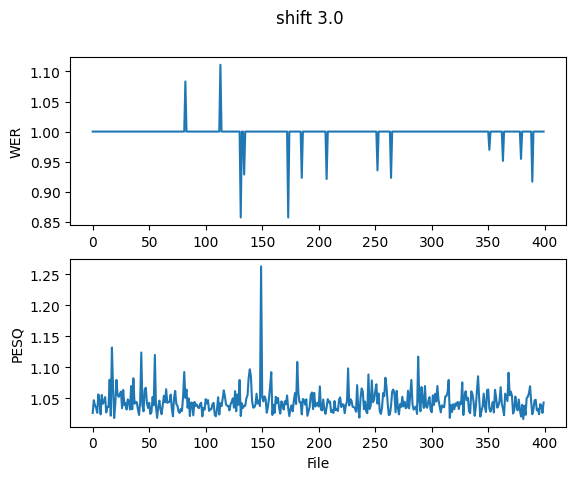

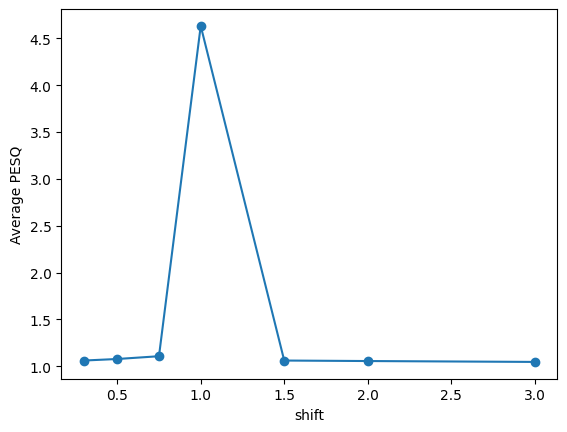

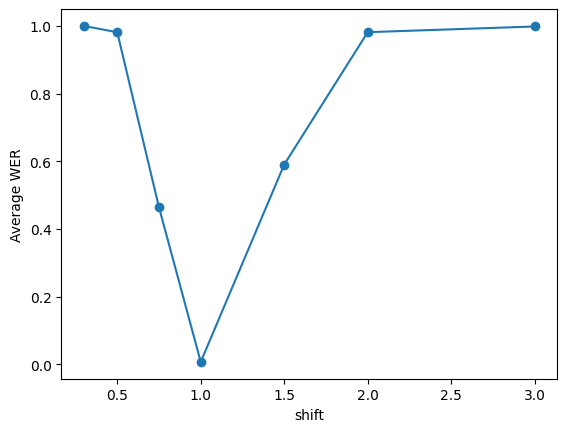

({3.0: {'WER': 0.9983303013477658, 'PESQ': 1.0450775}},
 {3.0: {'WER': [1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0833333333333333,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,
    1.0,

In [5]:


import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and extract the data
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["WER"] = np.clip(data["WER"], 0,2)

    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["shift"] = [float(shift) for shift in data["shift"]]


    # Group the data by shift
    grouped_data = {}
    for shift, wer, pesq in zip(data["shift"], data["WER"], data["PESQ"]):
        if shift not in grouped_data:
            grouped_data[shift] = {"WER": [], "PESQ": []}
        grouped_data[shift]["WER"].append(wer)
        grouped_data[shift]["PESQ"].append(pesq)

    # Calculate the average WER and PESQ for each shift
    avg_data = {}
    for shift, shift_data in grouped_data.items():
        avg_wer = np.mean(shift_data["WER"])
        avg_pesq = np.mean(shift_data["PESQ"])
        avg_data[shift] = {"WER": avg_wer, "PESQ": avg_pesq}

    return avg_data, grouped_data

output_file_paths = [
    Path("OUTPUT03SHIFT.tsv"),
    Path("OUTPUT05SHIFT.tsv"),
    Path("OUTPUT075SHIFT.tsv"),
    Path("OUTPUT1SHIFT.tsv"),
    Path("OUTPUT15SHIFT.tsv"),
    Path("OUTPUT2SHIFT.tsv"),
    Path("OUTPUT3SHIFT.tsv")
]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each shift
    for shift, shift_data in grouped_data.items():
        plt.figure()
        plt.suptitle(f"shift {shift}")
        plt.subplot(2, 1, 1)
        plt.plot(shift_data["WER"])
        plt.ylabel("WER")
        plt.subplot(2, 1, 2)
        plt.plot(shift_data["PESQ"])
        plt.xlabel("File")
        plt.ylabel("PESQ")
        plt.show()

# Plot the average WER data for all shifts
shifts = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]

# Call the plot_wer_pesq function for each file and collect the results
all_avg_data = {}
for output_file_path in output_file_paths:
    avg_data, grouped_data = plot_wer_pesq(output_file_path)
    all_avg_data.update(avg_data)

    # Plot the data for each shift
    # (same as before)

# Plot the average WER data for all shifts
shifts = list(all_avg_data.keys())
avg_wers = [data["WER"] for data in all_avg_data.values()]


# Plot the average PESQ data for all shifts
avg_pesqs = [data["PESQ"] for data in all_avg_data.values()]

plt.figure()
plt.plot(shifts, avg_pesqs, 'o-')
plt.xlabel("shift")
plt.ylabel("Average PESQ")
plt.show()

plt.figure()
plt.plot(shifts, avg_wers, 'o-')
plt.xlabel("shift")
plt.ylabel("Average WER")
plt.show()

output_file_path = Path("OUTPUT03SHIFT.tsv")
output_file_path1 = Path("OUTPUT05SHIFT.tsv")
output_file_path2 = Path("OUTPUT075SHIFT.tsv")
output_file_path3 = Path("OUTPUT1SHIFT.tsv")
output_file_path4 = Path("OUTPUT15SHIFT.tsv")
output_file_path5 = Path("OUTPUT2SHIFT.tsv")
output_file_path6 = Path("OUTPUT3SHIFT.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)
plot_wer_pesq(output_file_path5)
plot_wer_pesq(output_file_path6)



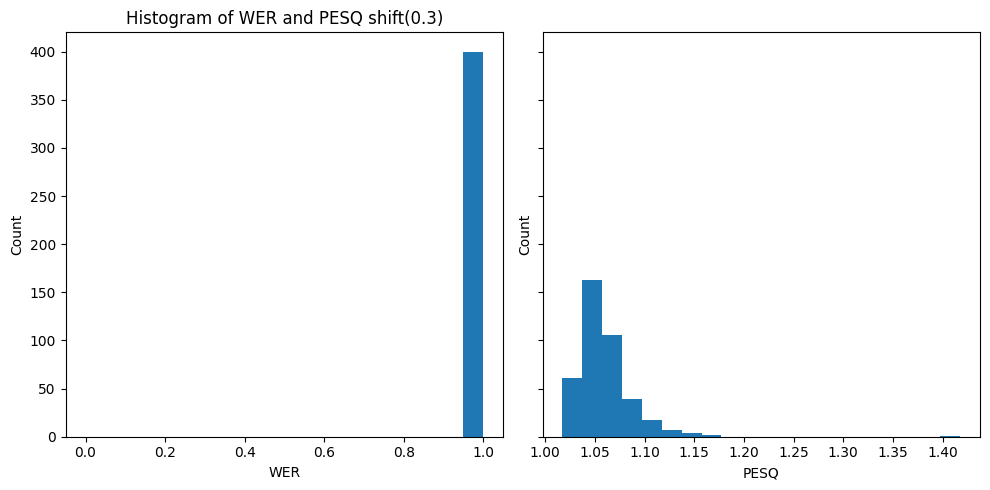

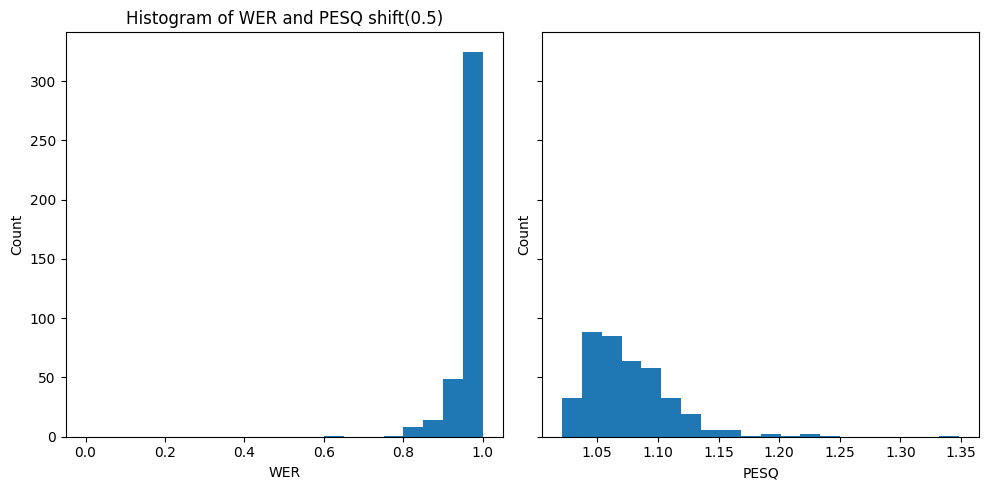

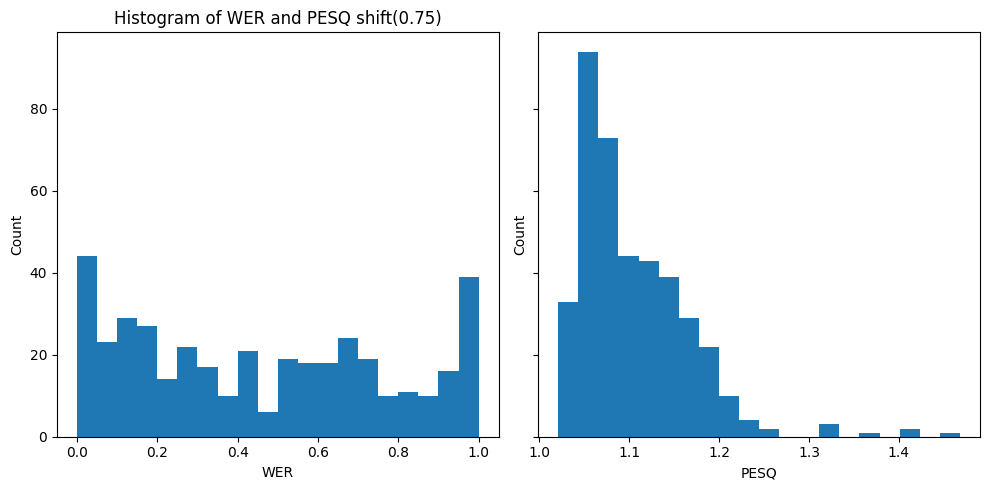

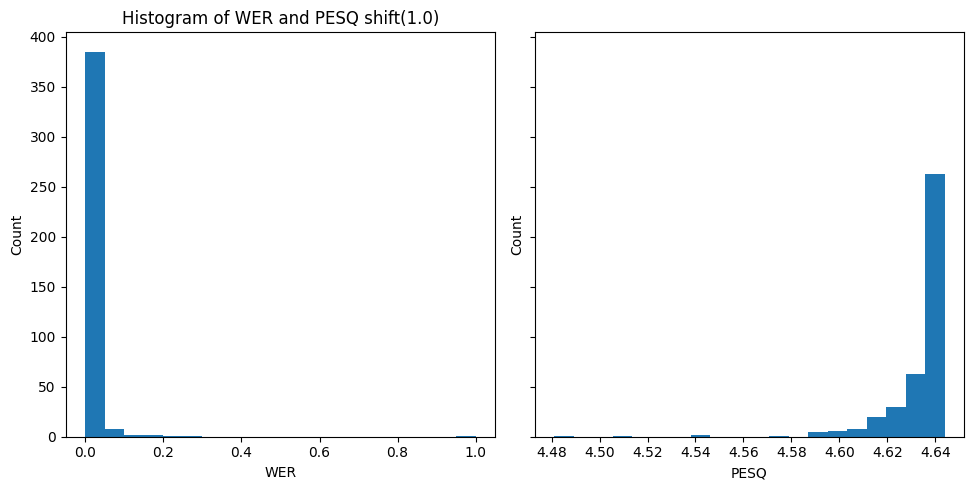

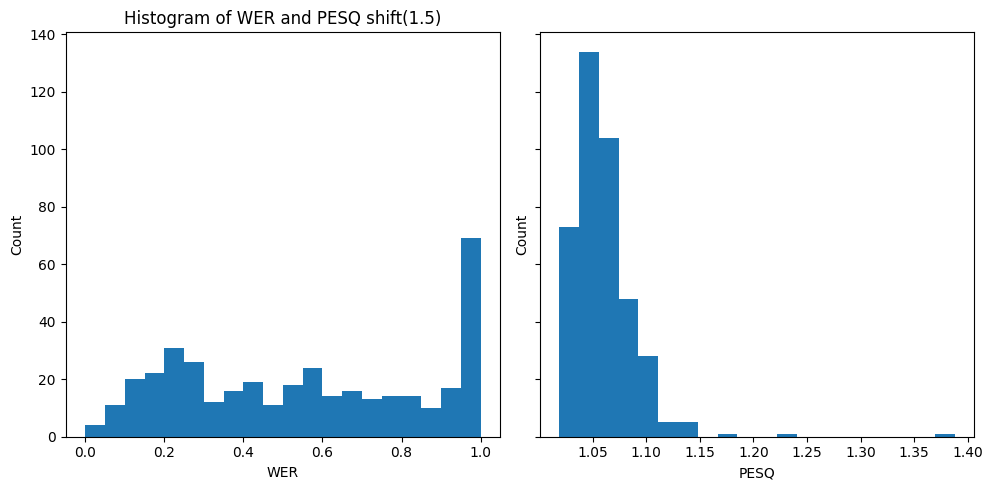

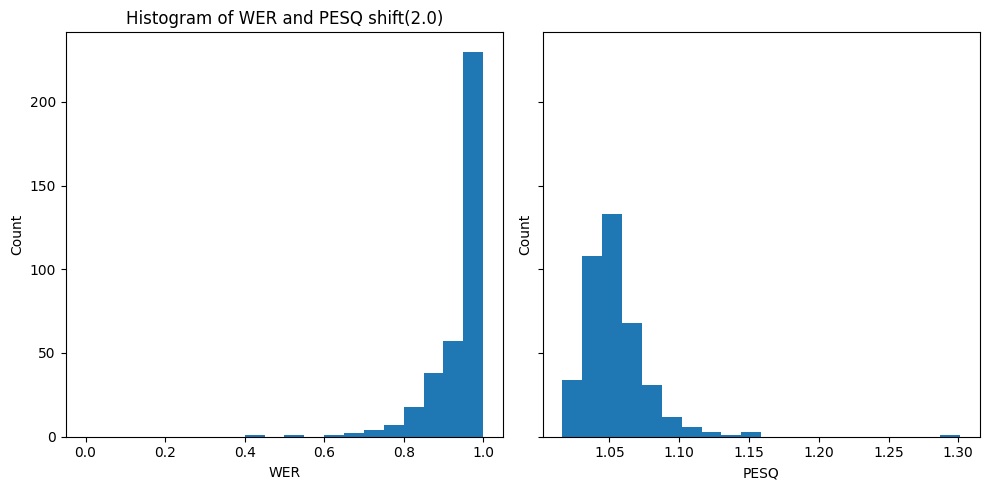

In [7]:
def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by shift
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["shift"] = [float(shift) for shift in data["shift"]]


    # Group the data by shift
    grouped_data = {}
    for shift, wer, pesq in zip(data["shift"], data["WER"], data["PESQ"]):
        if shift not in grouped_data:
            grouped_data[shift] = {"WER": [], "PESQ": []}
        grouped_data[shift]["WER"].append(wer)
        grouped_data[shift]["PESQ"].append(pesq)

    # Create subplots for each shift level
    num_shifts = len(grouped_data)
    if num_shifts == 1:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(num_shifts, 2, figsize=(10, 10), sharey=True)

    for i, (shift, shift_data) in enumerate(grouped_data.items()):
        # Create histograms for WER and PESQ scores
        axs[i][0].hist(shift_data["WER"], range=(0, 1), bins=20)
        axs[i][1].hist(shift_data["PESQ"], bins=20)

        # Add labels and titles
        axs[i][0].set_xlabel("WER")
        axs[i][1].set_xlabel("PESQ")
        if num_shifts == 1:
            axs[i][0].set_title(F"Histogram of WER and PESQ shift({shift})")
        else:
            axs[i][0].set_title(f"Histogram of WER (shift {shift})")
            axs[i][1].set_title(f"Histogram of PESQ (shift {shift})")
        axs[i][0].set_ylabel("Count")
        axs[i][1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

output_file_path = Path("OUTPUT03SHIFT.tsv")
output_file_path1 = Path("OUTPUT05SHIFT.tsv")
output_file_path2 = Path("OUTPUT075SHIFT.tsv")
output_file_path3 = Path("OUTPUT1SHIFT.tsv")
output_file_path4 = Path("OUTPUT15SHIFT.tsv")
output_file_path5 = Path("OUTPUT2SHIFT.tsv")
output_file_path6 = Path("OUTPUT3SHIFT.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)
plot_wer_pesq(output_file_path5)


In [ ]:

import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by shift
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["shift"] = [float(shift) for shift in data["shift"]]


    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], 0, 1)

    return data["shift"], data["WER"]

# Define colors for each shift value
shift_colors = {0.3: 'pink', 0.5: 'red', 0.75: 'blue', 1: 'green', 1.5: 'purple', 2: 'orange', 3: 'yellow'}

output_file_paths = [
    Path("OUTPUT03SHIFT.tsv"),
    Path("OUTPUT05SHIFT.tsv"),
    Path("OUTPUT075SHIFT.tsv"),
    Path("OUTPUT1SHIFT.tsv"),
    Path("OUTPUT15SHIFT.tsv"),
    Path("OUTPUT2SHIFT.tsv"),
    Path("OUTPUT3SHIFT.tsv")

]

wer_data = {}
for output_file_path in output_file_paths:
    shift, wer = plot_wer(output_file_path)
    for shift_value, wer_value in zip(shift, wer):
        if shift_value not in wer_data:
            wer_data[shift_value] = []
        wer_data[shift_value].append(wer_value)

plt.figure()
binwidth = 0.05
bins = np.arange(0, 1 + binwidth, binwidth)

for shift_value, wer_values in wer_data.items():
    color = shift_colors[shift_value]
    plt.hist(wer_values, bins=bins, color=color, histtype='step', label=f'shift {shift_value} clip')

#plt.ylim(0, 250)

plt.xlabel("WER")
plt.ylabel("Frequency")
plt.title("WER Histogram")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by shift
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["shift"] = [float(shift) for shift in data["shift"]]


    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["shift"], data["PESQ"]

# Define colors for each shift value
shift_colors = {0.3: 'pink', 0.5: 'red', 0.75: 'blue', 1: 'green', 1.5: 'purple', 2: 'orange', 3: 'yellow'}

output_file_paths = [
    Path("OUTPUT03SHIFT.tsv"),
    Path("OUTPUT05SHIFT.tsv"),
    Path("OUTPUT075SHIFT.tsv"),
    Path("OUTPUT1SHIFT.tsv"),
    Path("OUTPUT15SHIFT.tsv"),
    Path("OUTPUT2SHIFT.tsv"),
    Path("OUTPUT3SHIFT.tsv")

]

pesq_data = {}
for output_file_path in output_file_paths:
    shift, pesq = plot_pesq(output_file_path)
    for shift_value, pesq_value in zip(shift, pesq):
        if shift_value not in pesq_data:
            pesq_data[shift_value] = []
        pesq_data[shift_value].append(pesq_value)

plt.figure()
binwidth = 0.2
bins = np.arange(1, 5 + binwidth, binwidth)

for shift_value, pesq_values in pesq_data.items():
    color = shift_colors[shift_value]
    plt.hist(pesq_values, bins=bins, color=color, histtype='step', label=f'shift {shift_value} clip')

plt.xlabel("PESQ")
plt.ylabel("Frequency")
plt.title("PESQ Histogram")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

def plot_wer_pesq(output_file_paths):
    # Initialize an empty dictionary to store the grouped data
    grouped_data = {}
    
    for output_file_path in output_file_paths:
        # Read the output TSV file and group the data by shift
        with open(output_file_path, "r") as file:
            tsv_file = csv.reader(file, delimiter="\t")
            header = next(tsv_file)  # Skip header row
            for line in tsv_file:
                shift = float(line[3])
                wer = float(line[1])
                pesq = float(line[2])
                
                if shift not in grouped_data:
                    grouped_data[shift] = {'WER': [], 'PESQ': []}
                
                grouped_data[shift]['WER'].append(wer) 
                grouped_data[shift]['PESQ'].append(pesq)
    
    # Create a color map using seaborn
    shift_levels = sorted(grouped_data.keys())
    rgb_values = sns.color_palette("husl", len(shift_levels))
    shift_colors = dict(zip(shift_levels, rgb_values))

    plt.figure()
    

    for shift, data in grouped_data.items():
        wer = np.array(data['WER'])
        pesq = np.array(data['PESQ'])
        avg_wer = np.mean(wer)
        avg_pesq = np.mean(pesq)
        
        plt.scatter(pesq, wer, c=[shift_colors[shift]] * len(wer), label=f'shift {shift}clip', s=10)  # Set s=10 for smaller markers
        plt.scatter(avg_pesq, avg_wer, c='black', marker='x', s=100)
        plt.text(avg_pesq, avg_wer, f' ({avg_pesq:.2f}, {avg_wer:.2f})', fontsize=10, verticalalignment='bottom')



    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.ylim(0,1)
    plt.title("WER vs. PESQ")
    plt.legend()
    plt.show()

output_file_paths = [
    Path("OUTPUT03SHIFT.tsv"),
    Path("OUTPUT05SHIFT.tsv"),
    Path("OUTPUT075SHIFT.tsv"),
    Path("OUTPUT1SHIFT.tsv"),
    Path("OUTPUT15SHIFT.tsv"),
    Path("OUTPUT2SHIFT.tsv"),
    Path("OUTPUT3SHIFT.tsv")

]

plot_wer_pesq(output_file_paths)
